# Logistic Regression

### Introduction

We will be implementing Logistic Regression models for the provided dataset from scratch and using scikit-learn.

## Logistic Regression

The purpose of this implementation is to get familiar with Sentiment Classification. By the end of this, we will have your very own “Sentiment Analyzer”.

We are given with Large Movie Review Dataset that contains separate labeled train and test set. Our task is to train a Logistic Regression classifier on train set and report accuracy on test set.


#### Dataset

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg).

There are two top-level directories `[train/, test/]` corresponding to the training and test sets. Each contains `[pos/, neg/]` directories for the reviews with binary labels positive and negative. Within these directories, reviews are stored in text files named following the convention `<id>_<rating>.txt` where `id` is a unique id and `rating` is the star rating for that review on a 1-10 scale.


In [ ]:
import os
import random

train_path = r'LogisticReg_Dataset\train'
test_path = r'LogisticReg_Dataset\test'

def data_loading(path):
    data = []
    for analysis, label in [('pos', 1), ('neg', 0)]:
        analysis_area = os.path.join(path, analysis)
        data += [(open(os.path.join(analysis_area, filename), 'r', encoding='utf-8').read(), label) for filename in os.listdir(analysis_area)]
    
    random.shuffle(data)
    return data

train_data = data_loading(train_path)
test_data = data_loading(test_path)

print(f"Size of the training dataset: {len(train_data)}")
print(f"Size of the testing dataset: {len(test_data)}")



Size of the training dataset: 25000
Size of the testing dataset: 25000


In [ ]:
import re
import string

with open(r'LogisticReg_Dataset\stop_words.txt', 'r') as file:
    stop_words = set(file.read().splitlines())

pattern = re.compile(f"[{re.escape(string.punctuation)}]")

def text_preprocessing(text):
    text = text.lower()
    text = pattern.sub(" ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

def dataset_preprocessing(data):
    processed_data = []
    nan_count = 0

    for review, label in data:
        preprocessed_review = text_preprocessing(review)
        if not preprocessed_review:
            nan_count += 1
            continue
        processed_data.append((preprocessed_review, label))

    return processed_data, nan_count

train_data, nan_train_count = dataset_preprocessing(train_data)
test_data, nan_test_count = dataset_preprocessing(test_data)

print(f"Number of NaN values in training data: {nan_train_count}")
print(f"Number of NaN values in testing data: {nan_test_count}")
for review, label in train_data[-5:]:
    print("Label:", label)
    print("Review:", review)
    print("-----")
# print(train_data[0])


Number of NaN values in training data: 0
Number of NaN values in testing data: 0
Label: 0
Review: producers film offer pay funeral expenses anyone dies fright watching movie offered intensive psychotherapy anyone really enjoyed stinker young couple moves house woman looks like woman couple lived extremely boring predictable end ended caring anyone movie br br avoid one costs
-----
Label: 1
Review: imagine could anything wanted go anywhere wished anything ever dreamed thought alone imagine sharing gift love life would would powers worth soul dilemma presented captain christopher pike cage legendary pilot episode original star trek series famously deemed cerebral cold nbc brass rejected cage nevertheless ambitious costly pilot ever made history network time gene roddenberry want let effort expense go waste result truly classic star trek episode embeds cage frame story deepens extends emotional philosophical depth haunting tale landmark tv history one first truly serious sci fi stories ev

In [ ]:


with open(r'LogisticReg_Dataset\positive_words.txt', 'r') as file:
    positive_words = set(file.read().splitlines())

with open(r'LogisticReg_Dataset\negative_words.txt', 'r') as file:
    negative_words = set(file.read().splitlines())

def extract_features(text):
    tokens = set(text.split())
    
    positive_count = len(tokens & positive_words)
    negative_count = len(tokens & negative_words)
    
    return positive_count, negative_count

train_data_features = [(extract_features(review), label) for review, label in train_data]

positive_data_points = [data for data in train_data_features if data[1] == 1]
negative_data_points = [data for data in train_data_features if data[1] == 0]

print("Five positive class datapoints:")
for features, label in positive_data_points[:5]:
    print(f"Positive Words Count: {features[0]}, Negative Words Count: {features[1]}, Label: {label}")

print("\nFive negative class datapoints:")
for features, label in negative_data_points[:5]:
    print(f"Positive Words Count: {features[0]}, Negative Words Count: {features[1]}, Label: {label}")


Five positive class datapoints:
Positive Words Count: 11, Negative Words Count: 4, Label: 1
Positive Words Count: 5, Negative Words Count: 2, Label: 1
Positive Words Count: 6, Negative Words Count: 4, Label: 1
Positive Words Count: 10, Negative Words Count: 14, Label: 1
Positive Words Count: 8, Negative Words Count: 3, Label: 1

Five negative class datapoints:
Positive Words Count: 5, Negative Words Count: 29, Label: 0
Positive Words Count: 21, Negative Words Count: 38, Label: 0
Positive Words Count: 4, Negative Words Count: 3, Label: 0
Positive Words Count: 8, Negative Words Count: 13, Label: 0
Positive Words Count: 7, Negative Words Count: 10, Label: 0


In [4]:
import random

indices = list(range(len(train_data_features)))
random.seed(42)  
random.shuffle(indices)

split_index = int(0.9 * len(train_data_features))
train_indices = indices[:split_index]
eval_indices = indices[split_index:]
train_features_final = [train_data_features[i] for i in train_indices]
train_labels_final = [[label for _, label in train_data_features][i] for i in train_indices]
eval_features = [train_data_features[i] for i in eval_indices]
eval_labels = [[label for _, label in train_data_features][i] for i in eval_indices]

# print(f"Size of the final training dataset: {len(train_features_final)}")
# print(f"Size of the evaluation dataset: {len(eval_features)}")
# print(train_features_final[0])  



### Implementation from Scratch

In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate  # Step size for each iteration in gradient descent
        self.epochs = epochs  # Number of iterations for training
        self.weights = None
        self.bias = None
        self.train_losses = []  # List to store training loss values over epochs
        self.validation_losses = []  # List to store validation loss values over epochs

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))  # Sigmoid activation function

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip values to prevent log(0) and log(1)
        # Compute binary Cross-Entropy loss using NumPy's dot product for efficiency
        loss = -(np.dot(y_true, np.log(y_pred)) + np.dot(1 - y_true, np.log(1 - y_pred))) / len(y_true)
        return loss

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        num_features = x_train.shape[1] #No. of features in training data
        self.weights = np.zeros(num_features)  # Initialize weights with zeros
        self.bias = 0  # Initialize bias to 0
        
        for _ in tqdm(range(self.epochs), desc="Training Progress"):
            model = np.dot(x_train, self.weights) + self.bias  # [n_samples, n_features] dot [n_features,] -> [n_samples,]
            predictions = self.sigmoid(model)  # Apply sigmoid activation to get probabilities, shape remains [n_samples,]
            
            train_loss = self.cross_entropy_loss(y_train, predictions)
            self.train_losses.append(train_loss)  # Store the training loss
            
            # If validation data is provided
            if x_val is not None and y_val is not None:
                val_model = np.dot(x_val, self.weights) + self.bias # [n_samples, n_features] dot [n_features,] -> [n_samples,]
                val_predictions = self.sigmoid(val_model)
                val_loss = self.cross_entropy_loss(y_val, val_predictions)
                self.validation_losses.append(val_loss)  # Store the validation loss

            # Compute the gradient
            dw = (1 / len(y_train)) * np.dot(x_train.T, (predictions - y_train)) # [n_features, n_samples] dot [n_samples,] -> [n_features,]
            db = (1 / len(y_train)) * np.sum(predictions - y_train) #scalar value

            # Update weights and bias using gradient descent
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, x_test):
        model = np.dot(x_test, self.weights) + self.bias # [n_samples, n_features] dot [n_features,] -> [n_samples,]
        predictions = self.sigmoid(model) #shape remains [n_samples,]
        y_pred = [1 if i > 0.5 else 0 for i in predictions]  # Convert probabilities to binary labels
        return y_pred

    #     return accuracy, f1, confusion
    def calculate_accuracy(self,predicted_labels, true_labels):
        return np.mean(np.array(predicted_labels)==np.array(true_labels))
    
    def make_confusion_matrix(self,predicted_labels, true_labels):
        num_classes = len(np.unique(true_labels))
        confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
        for true_label, predicted_label in zip(true_labels, predicted_labels):
            confusion_matrix[true_label, predicted_label] += 1
        return confusion_matrix
    
    def calculate_precision(self,confusion_matrix,class_label):
        col_sum = np.sum(confusion_matrix[:, class_label])
        return 0 if col_sum == 0 else confusion_matrix[class_label, class_label] / col_sum
    
    def calculate_recall(self,confusion_matrix,class_label):
        row_sum = np.sum(confusion_matrix[class_label, :])
        return 0 if row_sum == 0 else confusion_matrix[class_label, class_label] / row_sum

    def calculate_f1_score(self,precision, recall):
        return 0 if precision + recall == 0 else 2 * (precision * recall) / (precision + recall)
    
    def evaluate(self, y_true, y_pred):
        # Calculate Accuracy
        accuracy = self.calculate_accuracy(y_pred, y_true)
        # Calculate Confusion Matrix
        confusion = self.make_confusion_matrix(y_pred, y_true)
        # We'll compute F1 score only for class_label = 1 (binary class problem)
        precision_val = self.calculate_precision(confusion, 1)
        recall_val = self.calculate_recall(confusion, 1)
        f1 = self.calculate_f1_score(precision_val, recall_val)

        return accuracy, f1, confusion
    
    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label="Training Loss", color='yellow')
        plt.plot(self.validation_losses, label="Validation Loss", color='purple', linestyle='dashdot')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training/Validation Loss over Epochs")
        plt.legend()
        plt.show()  # Plot training and validation losses over epochs


Training Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 5000/5000 [00:07<00:00, 670.95it/s]


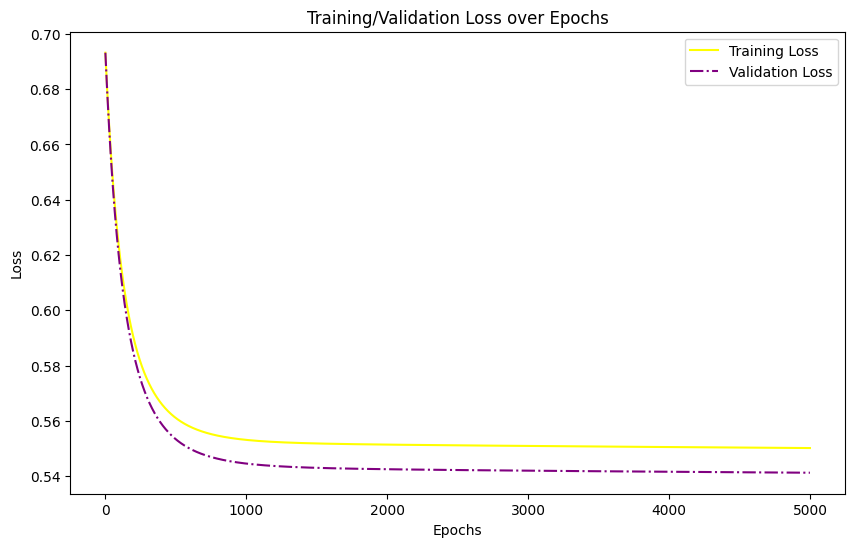

In [6]:
train_Xvals = [item[0] for item in train_features_final]
train_Yvals = [item[1] for item in train_features_final]
# print(train_Xvals[0])
eval_Xvals = [item[0] for item in eval_features]
eval_Yvals = [item[1] for item in eval_features]
# print(len(eval_Xvals))
# print(eval_Xvals)
# print(eval_data.shape)

model = LogisticRegression(learning_rate=0.001, epochs=5000)
model.fit(np.array(train_Xvals,dtype=float), np.array(train_Yvals,dtype=float), np.array(eval_Xvals,dtype=float), np.array(eval_Yvals,dtype=float))
model.plot_losses()

Accuracy: 73.00%
F1 Score: 0.7384
Confusion Matrix:
[[8723 3777]
 [2974 9526]]


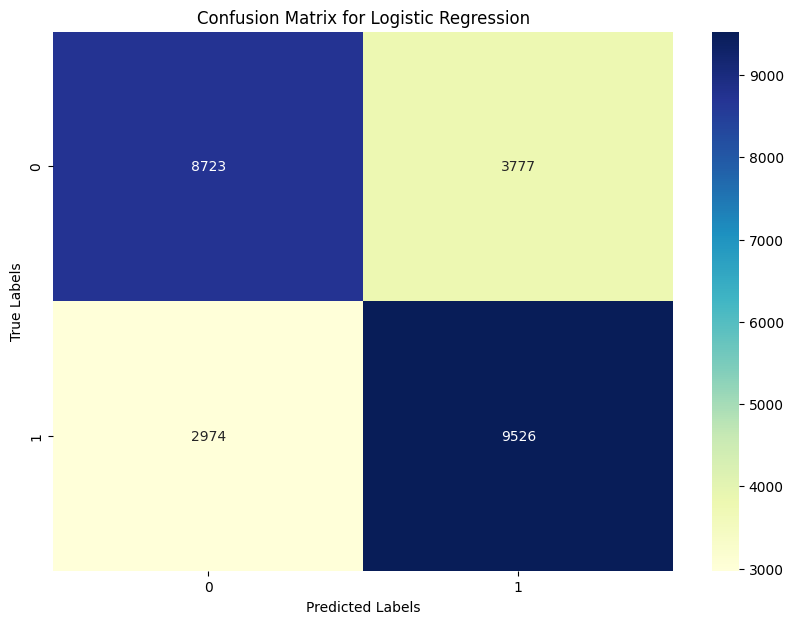

In [7]:
import seaborn as sns
feature_data_test = [(extract_features(review), label) for review, label in test_data]
test_Xvals = [item[0] for item in feature_data_test]
test_Yvals = [item[1] for item in feature_data_test]
# print((test_Xvals[0]))

pred_Yvals = model.predict(np.array(test_Xvals))

accuracy, f1, confusion = model.evaluate(test_Yvals, pred_Yvals)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion)
def make_heat_map(data, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(data, annot=True, fmt="d", cmap="YlGnBu")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
make_heat_map(confusion,title='Confusion Matrix for Logistic Regression')


### Use Scikit-learn

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

train_data_final, _, _, _ = train_test_split(train_data_features,[label for _, label in train_data_features],test_size=0.1,random_state=10,stratify=[label for _, label in train_data_features])
train_Xvals = [item[0] for item in train_data_final]
train_Yvals = [item[1] for item in train_data_final]
model = LogisticRegression(random_state=42).fit(train_Xvals, train_Yvals)
y_pred = model.predict(test_Xvals)
accuracy = accuracy_score(test_Yvals, y_pred)
print(f"Accuracy: {accuracy*100:.4f}")
f1 = f1_score(test_Yvals, y_pred)
print(f"F1 Score: {f1:.4f}")
conf_matrix = confusion_matrix(test_Yvals, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 73.2880
F1 Score: 0.7306
Confusion Matrix:
[[9269 3231]
 [3447 9053]]
